In [1]:
import sys
sys.path.append('../')

import torch 
import torch.nn as nn 
import torch.optim as optim
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from models.classification import NN, CNN
from compute_ntk import get_ntk, get_fnet_single
from utils import get_relative_norm

In [23]:
dataset = MNIST("../../coding/Dataset/", download=False, train=True, transform=ToTensor())

trainloader = DataLoader(dataset, batch_size=128)
x_ntk = torch.stack([dataset[i][0] for i in range(20)])

# Linear Model:

In [26]:
EPOCHS=2
ITER=2

results_dict = {
    50:[[0] for _ in range(ITER)],
    100:[[0] for _ in range(ITER)],
    500:[[0] for _ in range(ITER)],
    1000:[[0] for _ in range(ITER)],
    5000:[[0] for _ in range(ITER)],
    10000:[[0] for _ in range(ITER)],
}

In [ ]:
for dim in results_dict.keys():
    for iter in range(ITER):
        print(f'*** Working on model {dim} , iter {iter+1}/{ITER} ***')

        model = NN(dim)
        parameters = {k:v.detach() for k, v in model.named_parameters()}

        fnet_single = get_fnet_single(model)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        ntk_init = get_ntk(fnet_single, parameters, x_ntk, multi=True)

        pbar = trange(EPOCHS)

        for epoch in pbar:
            epoch_loss = 0
            for x, y in trainloader:
                pred = model(x)
                loss = criterion(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss+=loss.item()

            pbar.set_description(f"for epoch {epoch} ; training loss : {epoch_loss}")

            parameters = {k:v.detach() for k, v in model.named_parameters()}
            ntk = get_ntk(fnet_single, parameters, x_ntk, multi=True)
            rel_norm = get_relative_norm(ntk, ntk_init)
            results_dict[dim][iter].append(rel_norm)

*** Working on model 50 , iter 0 ***


  0%|          | 0/2 [00:00<?, ?it/s]

for epoch 1 ; training loss : 962.8801151514053: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it] 


*** Working on model 50 , iter 1 ***


for epoch 1 ; training loss : 947.4491676092148: 100%|██████████| 2/2 [00:03<00:00,  1.91s/it] 


*** Working on model 100 , iter 0 ***


for epoch 1 ; training loss : 896.2086839675903: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


*** Working on model 100 , iter 1 ***


for epoch 1 ; training loss : 894.0946269035339: 100%|██████████| 2/2 [00:04<00:00,  2.07s/it] 


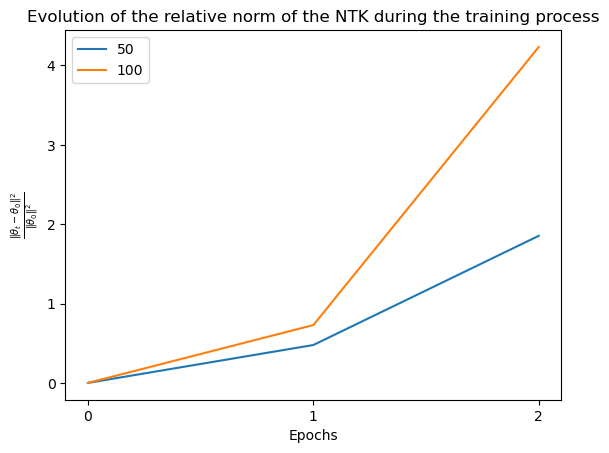

In [29]:
for dim in results_dict.keys():
    mean_results = np.mean(results_dict[dim], axis=0)
    plt.plot(mean_results, label=dim)

plt.xlabel('Epochs')
plt.ylabel(r'$\frac{\|\theta_t - \theta_0\|^2}{\|\theta_0\|^2}$')
plt.title("Evolution of the relative norm of the NTK during the training process")

epochs = np.arange(len(mean_results))
plt.xticks(epochs)

plt.legend()
plt.show()

# Convolutional Model:

In [41]:
EPOCHS=1
ITER=2

results_dict = {
    16:[[0] for _ in range(ITER)],
    32:[[0] for _ in range(ITER)],
    # 64:[[0] for _ in range(ITER)],
    # 128:[[0] for _ in range(ITER)],
    # 256:[[0] for _ in range(ITER)],
}

In [42]:
for dim in results_dict.keys():
    for iter in range(ITER):
        print(f'*** Working on model {dim} , iter {iter+1}/{ITER} ***')

        model = CNN(dim)
        parameters = {k:v.detach() for k, v in model.named_parameters()}

        fnet_single = get_fnet_single(model)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5)

        ntk_init = get_ntk(fnet_single, parameters, x_ntk)

        pbar = trange(EPOCHS)
        for epoch in pbar:
            epoch_loss = 0
            for x, y in trainloader:
                pred = model(x)
                loss = criterion(pred, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_loss+=loss.item()

            pbar.set_description(f"for epoch {epoch} ; training loss : {epoch_loss}")

            parameters = {k:v.detach() for k, v in model.named_parameters()}
            ntk = get_ntk(fnet_single, parameters, x_ntk)
            rel_norm = get_relative_norm(ntk, ntk_init)
            results_dict[dim][iter].append(rel_norm)

*** Working on model 16 , iter 1/2 ***


for epoch 0 ; training loss : 917.1595839262009: 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]


*** Working on model 16 , iter 2/2 ***


for epoch 0 ; training loss : 881.1449667215347: 100%|██████████| 1/1 [00:06<00:00,  6.39s/it]


*** Working on model 32 , iter 1/2 ***


for epoch 0 ; training loss : 762.3291660547256: 100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


*** Working on model 32 , iter 2/2 ***


for epoch 0 ; training loss : 821.6434372663498: 100%|██████████| 1/1 [00:08<00:00,  8.92s/it]


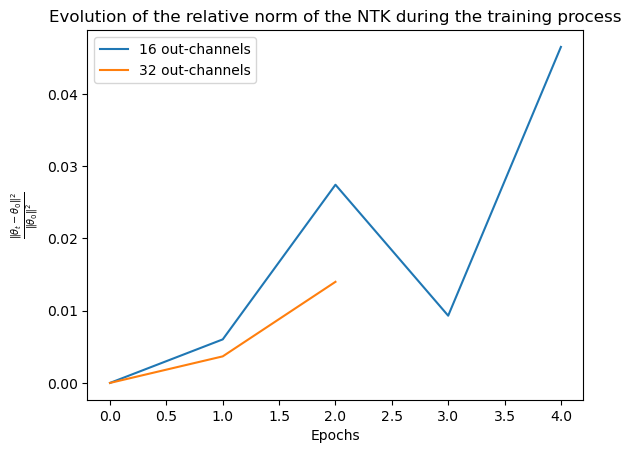

In [36]:
for dim in results_dict.keys():
    mean_results=np.mean(results_dict[dim], axis=0)
    plt.plot(mean_results, label=f"{dim} out-channels")

plt.xlabel('Epochs')
plt.ylabel(r'$\frac{\|\theta_t - \theta_0\|^2}{\|\theta_0\|^2}$')
plt.title("Evolution of the relative norm of the NTK during the training process")
epochs = np.arange(len(mean_results))
plt.xticks(epochs)
plt.legend()
